In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, GaussianNB

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
import xgboost
from xgboost import  XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.utils import to_categorical

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns  # for nicer plots

2024-03-17 00:16:33.701081: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-17 00:16:34.236937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 00:16:34.236968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 00:16:34.335740: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-17 00:16:34.522628: I tensorflow/core/platform/cpu_feature_guar

In [2]:
apple_data = pd.read_csv("apple_processed_data.csv", index_col=0)
tesla_data = pd.read_csv("tesla_processed_data.csv", index_col=0)


In [3]:
tesla_data.head()

,Date,close,open,lowest,highest,total_vol,mean_vol,std_vol,news,month,day,is_up
0,2015-01-02,14.613,14.865,14.217,14.883,59157390,151685.615385,155760.920466,,1,2,0
1,2015-01-05,14.001,14.351,13.811,14.433,68662800,176058.461538,168290.638752,,1,5,1
2,2015-01-06,14.079,14.003,13.614,14.280,80752635,207058.038462,152662.243747,,1,6,0
3,2015-01-07,14.054,14.219,13.985,14.319,38728110,99558.123393,100907.065350,['BMW revives wireless charging to reduce elec...,1,7,0
4,2015-01-08,14.037,14.216,14.001,14.253,43839960,112699.125964,130930.670726,['How oil at $50 could change almost everythin...,1,8,0


In [4]:
def train_valid_test(data, target, split):
    train, valid, test = split
    n = data.shape[0]
    train_end = int(train * n)
    valid_end = int(n * (train + valid))
    print(valid_end)
    x_train, y_train = data[:train_end], target[:train_end]
    x_val, y_val = data[train_end:valid_end], target[train_end:valid_end]
    x_test, y_test = data[valid_end:], target[valid_end:]

    return x_train, y_train, x_val, y_val, x_test, y_test

In [5]:
def preprocess_data(data):
    lag = 7
    result = data.copy()
    result['ema'] = result['close'].ewm(span=lag).mean()
    for i in range(1, lag+1):
        result['lag_' + str(i)] = result['close'].shift(i)

    result = result.iloc[lag:]
    # Assuming df is your DataFrame and it has 'day' and 'month' columns
    result['month_sin'] = np.sin(2 * np.pi * result['month']/12)
    result['month_cos'] = np.cos(2 * np.pi * result['month']/12)
    result['day_sin'] = np.sin(2 * np.pi * result['day']/31)
    result['day_cos'] = np.cos(2 * np.pi * result['day']/31)
    return result

In [6]:
data = preprocess_data(apple_data)

/tmp/ipykernel_1405/898176073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month_sin'] = np.sin(2 * np.pi * data['month']/12)
/tmp/ipykernel_1405/898176073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month_cos'] = np.cos(2 * np.pi * data['month']/12)
/tmp/ipykernel_1405/898176073.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [7]:
data.head()

,Date,close,open,lowest,highest,total_vol,mean_vol,std_vol,news,month,...,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,month_sin,month_cos,day_sin,day_cos
7,2015-01-13,24.697,24.958,24.375,25.297,242520180,621846.615385,402625.780292,Zomato to buy US food portal Urbanspoon for $6...,1,...,25.095,25.066,24.143,23.802,23.807,24.490,0.5,0.866025,0.485302,-0.874347
8,2015-01-14,24.600,24.468,24.283,24.779,166619520,427229.538462,308052.905151,"['60,000 mobiles sold in a flash sale but Amaz...",1,...,24.481,25.095,25.066,24.143,23.802,23.807,0.5,0.866025,0.299363,-0.954139
9,2015-01-15,23.936,24.521,23.871,24.682,205693220,527418.512821,391931.336059,"['60,000 mobiles sold in a flash sale but Amaz...",1,...,24.697,24.481,25.095,25.066,24.143,23.802,0.5,0.866025,0.101168,-0.994869
10,2015-01-16,23.746,23.990,23.545,24.126,231737276,594198.143590,691319.500876,"['60,000 mobiles sold in a flash sale but Amaz...",1,...,24.600,24.697,24.481,25.095,25.066,24.143,0.5,0.866025,-0.101168,-0.994869
11,2015-01-20,24.358,24.051,23.836,24.395,155383068,398418.123077,419122.611125,"['60,000 mobiles sold in a flash sale but Amaz...",1,...,23.936,24.600,24.697,24.481,25.095,25.066,0.5,0.866025,-0.790776,-0.612106


In [8]:
predictors = data.drop(['is_up', 'Date', 'news', 'day', 'month', 'total_vol', 'mean_vol', 'std_vol', 'open', 'lowest', 'highest'], axis=1)
target = data['is_up']

In [9]:
x_train, y_train, x_val, y_val, x_test, y_test = train_valid_test(predictors, target, (0.6, 0.2, 0.2))


1772


In [10]:
predictors.head()

,close,ema,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,month_sin,month_cos,day_sin,day_cos
7,24.697,24.598054,24.481,25.095,25.066,24.143,23.802,23.807,24.490,0.5,0.866025,0.485302,-0.874347
8,24.600,24.598580,24.697,24.481,25.095,25.066,24.143,23.802,23.807,0.5,0.866025,0.299363,-0.954139
9,23.936,24.423050,24.600,24.697,24.481,25.095,25.066,24.143,23.802,0.5,0.866025,0.101168,-0.994869
10,23.746,24.246324,23.936,24.600,24.697,24.481,25.095,25.066,24.143,0.5,0.866025,-0.101168,-0.994869
11,24.358,24.275156,23.746,23.936,24.600,24.697,24.481,25.095,25.066,0.5,0.866025,-0.790776,-0.612106


## Transform data

In [11]:
sc = MinMaxScaler()
sc.fit(x_train)
x_train_scaled = sc.transform(x_train)
x_val_scaled = sc.transform(x_val)
x_test_scaled = sc.transform(x_test)


X_train_for_compare = np.append(x_train_scaled, x_val_scaled, axis=0)
Y_train_for_compare = np.append(y_train, y_val, axis=0)

## Baseline model
According to EDA, the market was up ~ 52% of the days, so the simplest model would be always predict up, which could potentially achieve 52% accuracy.

In [12]:
counting = data['is_up'].value_counts()
BASELINE = counting[1] / np.sum(counting)
BASELINE

0.526173285198556

In [13]:
accuracy_score(y_val, [1] * len(y_val))

0.5372460496613995

The baseline model has accuracy of ~ **54%**

## Default hyperparameters with some Algo

Logistic regression

In [14]:
lr = LogisticRegression(random_state = 12)
lr.fit(x_train_scaled, y_train)

print("Training accuracy:", lr.score(x_train_scaled, y_train))
print("Validation accuracy:", lr.score(x_val_scaled, y_val))

Training accuracy: 0.5515425131677953
Validation accuracy: 0.5146726862302483


K Nearest Neighbors:

In [15]:
knn = KNeighborsClassifier()
knn.fit(x_train_scaled, y_train)

print("Training accuracy:", knn.score(x_train_scaled, y_train))
print("Validation accuracy:", knn.score(x_val_scaled, y_val))

Training accuracy: 0.674191121143717
Validation accuracy: 0.49435665914221216


SVM

In [16]:
svm = SVC()
svm.fit(x_train_scaled, y_train)
print("Training accuracy:", svm.score(x_train_scaled, y_train))
print("Validation accuracy:", svm.score(x_val_scaled, y_val))

Training accuracy: 0.580887885628292
Validation accuracy: 0.5146726862302483


Naive Bayes

In [17]:
bnb = BernoulliNB()
bnb.fit(x_train_scaled, y_train)
print("Training accuracy:", bnb.score(x_train_scaled, y_train))
print("Validation accuracy:", bnb.score(x_val_scaled, y_val))


Training accuracy: 0.5327313769751693
Validation accuracy: 0.5056433408577878


Random Forest Classifier

In [18]:
rf = RandomForestClassifier(bootstrap=True, random_state = 7)
rf.fit(x_train_scaled, y_train)

print("Training accuracy:", rf.score(x_train_scaled, y_train))
print("Validation accuracy:", rf.score(x_val_scaled, y_val))

Training accuracy: 1.0
Validation accuracy: 0.4717832957110609


In [19]:
sorted(list(zip(predictors.columns, rf.feature_importances_)), key= lambda x: -x[1])

[('close', 0.10043040464661328),
 ('lag_7', 0.0923772109345861),
 ('lag_4', 0.09080118022033785),
 ('lag_1', 0.08971064976791042),
 ('lag_3', 0.08918385435173042),
 ('lag_6', 0.08835685626955618),
 ('lag_5', 0.08765580392616842),
 ('lag_2', 0.08430168548567064),
 ('ema', 0.08324976139602493),
 ('day_sin', 0.0738084676072697),
 ('day_cos', 0.05805155674978601),
 ('month_sin', 0.031503648923904774),
 ('month_cos', 0.030568919720441262)]

CatBoostClassifier

In [20]:
cat = CatBoostClassifier(silent=True, random_state = 12)
cat.fit(x_train_scaled, y_train)

print("Training accuracy:", cat.score(x_train_scaled, y_train))
print("Validation accuracy:", cat.score(x_val_scaled, y_val))
print("Test accuracy:", cat.score(x_test_scaled, y_test))

Training accuracy: 0.8465011286681715
Validation accuracy: 0.4785553047404063
Test accuracy: 0.46621621621621623


XGBoost Classifier 

In [21]:
xg = XGBClassifier()
xg.fit(x_train_scaled, y_train)

print("Training accuracy:", xg.score(x_train_scaled, y_train))
print("Validation accuracy:", xg.score(x_val_scaled, y_val))
print("Test accuracy:", xg.score(x_test_scaled, y_test))

Training accuracy: 0.9977426636568849
Validation accuracy: 0.4582392776523702
Test accuracy: 0.4774774774774775


Simple Deep Learning

In [30]:
x_train_lstm = np.reshape(X_train_for_compare, (X_train_for_compare.shape[0], X_train_for_compare.shape[1], 1))

num_epochs = 15
model = tf.keras.Sequential()
unit = 50
model.add(LSTM(unit, return_sequences=True, input_shape=(x_train_lstm.shape[1], 1)))
model.add(LSTM(unit))
model.add(Dropout(0.2))
model.add(Dense(units=25, activation = 'tanh'))
model.add(Dense(1, activation = 'sigmoid'))

# optimizer = tf.keras.optimizers.Nadam()
optimizer = tf.keras.optimizers.Adagrad()

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])
history = model.fit(x_train_lstm, Y_train_for_compare, validation_data = (x_val_scaled, y_val), batch_size=1, epochs=num_epochs)

threshold = 0.5
y_val_pred = (model.predict(x_val_scaled) >= threshold).astype(int)
print("Training accuracy:", accuracy_score(y_train, (model.predict(x_train_scaled) > threshold).astype(int)))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))
print("Test accuracy:", model.evaluate(x_test_scaled, y_test))

Epoch 1/15
1772/1772 [==============================] - 14s 7ms/step - loss: 0.6925 - accuracy: 0.5277 - val_loss: 0.6913 - val_accuracy: 0.5372
Epoch 2/15
1772/1772 [==============================] - 12s 7ms/step - loss: 0.6923 - accuracy: 0.5248 - val_loss: 0.6912 - val_accuracy: 0.5372
Epoch 3/15
1772/1772 [==============================] - 12s 7ms/step - loss: 0.6918 - accuracy: 0.5282 - val_loss: 0.6911 - val_accuracy: 0.5372
Epoch 4/15
1772/1772 [==============================] - 12s 7ms/step - loss: 0.6917 - accuracy: 0.5310 - val_loss: 0.6911 - val_accuracy: 0.5372
Epoch 5/15
1772/1772 [==============================] - 12s 7ms/step - loss: 0.6917 - accuracy: 0.5316 - val_loss: 0.6910 - val_accuracy: 0.5372
Epoch 6/15
1772/1772 [==============================] - 12s 7ms/step - loss: 0.6921 - accuracy: 0.5265 - val_loss: 0.6910 - val_accuracy: 0.5372
Epoch 7/15
1772/1772 [==============================] - 12s 7ms/step - loss: 0.6913 - accuracy: 0.5310 - val_loss: 0.6910 - val_ac

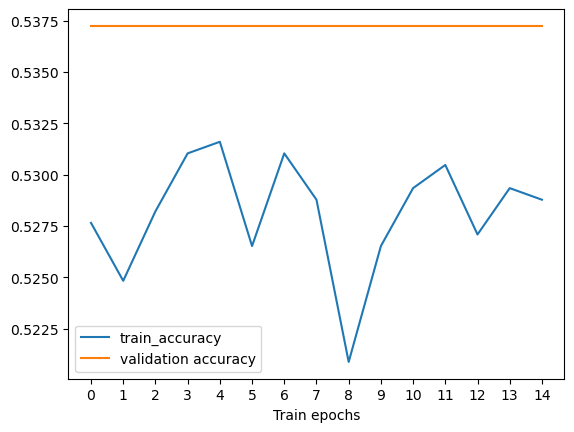

In [31]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(num_epochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

## Optimize hyper params

In [32]:
import optuna
from optuna import Trial

optuna.logging.set_verbosity(optuna.logging.WARNING)

n_trials = 100
random_state = 7

### Logis Regression

In [33]:
def lr_optimize(trial: Trial):
    solver = trial.suggest_categorical("solver", ["lbfgs", 'newton-cholesky'])
    penalty = trial.suggest_categorical("penalty", ['l2', None])
    lr = LogisticRegression(penalty=penalty, solver=solver, random_state=random_state, max_iter=500, multi_class = 'ovr')
    lr.fit(x_train_scaled, y_train)
    y_val_pred = lr.predict(x_val_scaled)
    return accuracy_score(y_val, y_val_pred)

lr_study = optuna.create_study(direction="maximize")
lr_study.optimize(lr_optimize, n_trials=n_trials)
print("Best params", lr_study.best_params)
print("Best accuracy", lr_study.best_value)

Best params {'solver': 'lbfgs', 'penalty': 'l2'}
Best accuracy 0.5146726862302483


### Random Forest

In [34]:
def rf_optimize(trial: Trial):
    n_estimators = trial.suggest_int('n_estimators', low=10, high = 100)
    criterion = trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss'])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    rf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, bootstrap=bootstrap)
    lr.fit(x_train_scaled, y_train)
    y_val_pred = lr.predict(x_val_scaled)
    return accuracy_score(y_val, y_val_pred)

rf_study = optuna.create_study(direction="maximize")
rf_study.optimize(rf_optimize, n_trials=n_trials)
print("Best params", rf_study.best_params)
print("Best accuracy", rf_study.best_value)

Best params {'n_estimators': 39, 'criterion': 'gini', 'bootstrap': False}
Best accuracy 0.5146726862302483


### CatBoost

In [35]:
def catboost_optimize(trial: Trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 1, 20),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'loss_function': 'Logloss',
        'verbose': False
    }
    model = CatBoostClassifier(**param)
    model.fit(x_train_scaled, y_train, eval_set=[(x_val_scaled, y_val)], early_stopping_rounds=100, verbose=0)
    preds = model.predict(x_val_scaled)
    accuracy = accuracy_score(y_val, preds)
    return accuracy

cat_study = optuna.create_study(direction="maximize")
cat_study.optimize(catboost_optimize, n_trials=n_trials)
print("Best params", cat_study.best_params)
print("Best accuracy", cat_study.best_value)

Best params {'iterations': 802, 'depth': 8, 'learning_rate': 0.21097019438094816, 'random_strength': 2, 'bagging_temperature': 0.5197456418335619, 'l2_leaf_reg': 0.6986463160504206, 'border_count': 7}
Best accuracy 0.5688487584650113


### Neural Network

In [36]:


def create_lstm(units):
    model = tf.keras.Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(x_train_lstm.shape[1], 1)))
    model.add(LSTM(units))
    model.add(Dropout(0.2))
    model.add(Dense(units=units//2, activation = 'tanh'))
    model.add(Dense(1, activation = 'sigmoid'))
    return model



def create_lstm_study(trial: Trial):
    units = trial.suggest_int("units", low=10, high = 50)
    model = create_lstm(units)
    optimizer = trial.suggest_categorical('optimizer', 
                                         ["Adam", "SGD", "RMSprop", "Adagrad"])
    batch_size = trial.suggest_int('batch_size', low=1, high = 15)
    epochs = trial.suggest_int('epochs', low=1, high=3)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    model.compile(optimizer=getattr(tf.keras.optimizers, optimizer)(learning_rate=lr), loss="binary_crossentropy", metrics=['accuracy'])
    model.fit(x_train_lstm, Y_train_for_compare, validation_data = (x_val_scaled, y_val), batch_size=batch_size, epochs=epochs, verbose=0)
    threshold = 0.5
    y_val_pred = (model.predict(x_val_scaled) >= threshold).astype(int)
    return accuracy_score(y_val, y_val_pred)

def run_study(function):
    # Create an Optuna study and optimize the objective
    study = optuna.create_study(direction='maximize')
    study.optimize(function, n_trials=10)
    
    print("Best trial:")
    trial = study.best_trial
    
    print(f"Accuracy: {trial.value}")
    print("Best hyperparameters:")
    for key, value in trial.params.items():
        print(f"{key}: {value}")

In [37]:
run_study(create_lstm_study)

14/14 [==============================] - 0s 3ms/step
Best trial:
Accuracy: 0.5598194130925508
Best hyperparameters:
units: 43
optimizer: Adagrad
batch_size: 13
epochs: 1
lr: 0.006957392490504836


In [38]:
def create_lstm_2(units):
    model = tf.keras.Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(x_train_lstm.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units))
    model.add(Dropout(0.2))
    model.add(Dense(units//2, activation = "tanh"))
    model.add(Dense(1, activation = 'tanh'))
    return model

def create_lstm_study_2(trial: Trial):
    units = trial.suggest_int("units", low=10, high = 50)
    model = create_lstm_2(units)
    optimizer = trial.suggest_categorical('optimizer', 
                                         ["Adam", "SGD", "RMSprop", "Adagrad"])
    batch_size = trial.suggest_int('batch_size', low=1, high = 15)
    epochs = trial.suggest_int('epochs', low=1, high=3)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    model.compile(optimizer=getattr(tf.keras.optimizers, optimizer)(learning_rate=lr), loss="binary_crossentropy", metrics=['accuracy'])
    model.fit(x_train_lstm, Y_train_for_compare, validation_data = (x_val_scaled, y_val), batch_size=batch_size, epochs=epochs, verbose=0)
    threshold = 0
    y_val_pred = (model.predict(x_val_scaled) >= threshold).astype(int)
    return accuracy_score(y_val, y_val_pred)

run_study(create_lstm_study_2)

14/14 [==============================] - 0s 3ms/step
Best trial:
Accuracy: 0.5372460496613995
Best hyperparameters:
units: 14
optimizer: Adam
batch_size: 4
epochs: 2
lr: 3.975159753000951e-05


In [39]:
def create_lstm_gru(units):
    model = tf.keras.Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(x_train_lstm.shape[1], 1)))
    model.add(LSTM(units))
    model.add(Dropout(0.2))
    model.add(GRU(units))
    model.add(Dropout(0.2))
    model.add(Dense(units//2, activation = "tanh"))
    model.add(Dense(1, activation = 'sigmoid'))
    return model

def create_lstm_gru_study(trial: Trial):
    units = trial.suggest_int("units", low=10, high = 50)
    model = create_lstm_2(units)
    optimizer = trial.suggest_categorical('optimizer', 
                                         ["Adam", "SGD", "RMSprop", "Adagrad"])
    batch_size = trial.suggest_int('batch_size', low=1, high = 15)
    epochs = trial.suggest_int('epochs', low=1, high=3)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    model.compile(optimizer=getattr(tf.keras.optimizers, optimizer)(learning_rate=lr), loss="binary_crossentropy", metrics=['accuracy'])
    model.fit(x_train_lstm, Y_train_for_compare, validation_data = (x_val_scaled, y_val), batch_size=batch_size, epochs=epochs, verbose=0)
    threshold = 0.5
    y_val_pred = (model.predict(x_val_scaled) >= threshold).astype(int)
    return accuracy_score(y_val, y_val_pred)

run_study(create_lstm_gru_study)

14/14 [==============================] - 0s 3ms/step
Best trial:
Accuracy: 0.5372460496613995
Best hyperparameters:
units: 47
optimizer: Adam
batch_size: 14
epochs: 1
lr: 0.002419610503285418


In [40]:
def create_neural_network_model():
    nn = tf.keras.Sequential()
    nn.add(Dense(32, activation='relu', input_shape=(len(x_train_scaled[0]),)))
    nn.add(Dense(1, activation = "sigmoid"))

    return nn
    
def create_neural_network_study(trial: Trial):
    model = create_neural_network_model()
    optimizer = trial.suggest_categorical('optimizer', 
                                         ["Adam", "SGD", "RMSprop", "Adagrad"])
    batch_size = trial.suggest_int('batch_size', low=1, high = 15)
    epochs = trial.suggest_int('epochs', low=1, high=5)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    model.compile(optimizer=getattr(tf.keras.optimizers, optimizer)(learning_rate=lr), loss="binary_crossentropy", metrics=['accuracy'])
    model.fit(x_train_lstm, Y_train_for_compare, validation_data = (x_val_scaled, y_val), batch_size=batch_size, epochs=epochs, verbose=0)
    threshold = 0.5
    y_val_pred = (model.predict(x_val_scaled) >= threshold).astype(int)
    return accuracy_score(y_val, y_val_pred)
    
run_study(create_neural_network_study)

14/14 [==============================] - 0s 984us/step
Best trial:
Accuracy: 0.5417607223476298
Best hyperparameters:
optimizer: SGD
batch_size: 12
epochs: 3
lr: 0.010489360088417304
